
<center> <h1>  </h1> </center>
<center> <h1> Coputer Vision through CNN Transfer Learning - ResNet50 </h1> </center>

<p style="margin-bottom:1cm;"></p>



# Task

In part 1, we coded up a ResNet-50 model with imagenet weights that have been pretrained on the imagenet dataset. We made no alterations to the model and had not train the model on our dataset. The predictions were underwhelming to say the least.

Lets fix that!

In this notebook, we will run a  Resnet 50 model and train it with our butterfly dataset (transfer learning) and try different parameters to see how our model improves.

- data augmentation
    - zoom
    - horizontal and vertical flip
    - rotation

- Max and Min.
 number of training examples per class

- tackling  dataset imbalance

- try predicting lower levels of the hierarchy species

# Import Libraries

In [1]:
import os
import glob
import numpy as np
import pandas as pd

from datetime import datetime

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam

# Load data


In [ ]:
!pip install gdown
!gdown 'https://docs.google.com/uc?export=download&id=13ImSEBk74HST4AUvhAjzIC4DwL0V4UOz' -O butterflies.zip

Downloading...
From (original): https://docs.google.com/uc?export=download&id=13ImSEBk74HST4AUvhAjzIC4DwL0V4UOz
From (redirected): https://docs.google.com/uc?export=download&id=13ImSEBk74HST4AUvhAjzIC4DwL0V4UOz&confirm=t&uuid=2062742d-a7f5-4527-afe6-3e25ccff034c
To: /content/butterflies.zip
100% 1.75G/1.75G [00:22<00:00, 77.1MB/s]


In [ ]:
!unzip butterflies.zip

Streaming output truncated to the last 5000 lines.
  inflating: butterflies/images/2017_05_24R/ETHZ_ENT01_2017_05_24_034253.JPG  
  inflating: butterflies/images/2017_05_24R/ETHZ_ENT01_2017_05_24_034247.JPG  
  inflating: butterflies/images/2017_05_24R/ETHZ_ENT01_2017_05_24_034521.JPG  
  inflating: butterflies/images/2017_05_24R/ETHZ_ENT01_2017_05_24_034509.JPG  
  inflating: butterflies/images/2017_05_24R/ETHZ_ENT01_2017_05_24_034482.JPG  
  inflating: butterflies/images/2017_05_24R/ETHZ_ENT01_2017_05_24_034496.JPG  
  inflating: butterflies/images/2017_05_24R/ETHZ_ENT01_2017_05_24_034441.JPG  
  inflating: butterflies/images/2017_05_24R/ETHZ_ENT01_2017_05_24_034327.JPG  
  inflating: butterflies/images/2017_05_24R/ETHZ_ENT01_2017_05_24_034333.JPG  
  inflating: butterflies/images/2017_05_24R/ETHZ_ENT01_2017_05_24_034455.JPG  
  inflating: butterflies/images/2017_05_24R/ETHZ_ENT01_2017_05_24_034469.JPG  
  inflating: butterflies/images/2017_05_24R/ETHZ_ENT01_2017_05_24_033851.JPG  
 

In [ ]:
!ls

butterflies  butterflies.zip  sample_data


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import butterflies.helper_cnn as hp

In [ ]:
def df_from_json(json_path, image_path):
  tdf = pd.read_json(json_path, orient='index')
  tdf['image_name'] = tdf['image_path'] + '/' + tdf['image_name']
  tdf['species'] = tdf['genus'] + '_' + tdf['specific_epithet']

  image_path = os.path.join(image_path, '')
  list_image_paths = glob.glob(image_path+'*/*.JPG')
  list_image_paths = [x.replace(image_path,'') for x in list_image_paths]
  check_image_bool = tdf['image_name'].apply(lambda x: x in list_image_paths)
  tdf = tdf[check_image_bool]

  print('loaded {}.json with shape {}'.format(json_path, tdf.shape))
  return tdf

In [ ]:
images_dir = "butterflies/images"

df_train_all = df_from_json("butterflies/splits/train.json", images_dir)
df_val_all = df_from_json("butterflies/splits/val.json", images_dir)
df_test_all = df_from_json("butterflies/splits/test.json", images_dir)

loaded butterflies/splits/train.json.json with shape (21928, 16)
loaded butterflies/splits/val.json.json with shape (2979, 16)
loaded butterflies/splits/test.json.json with shape (3165, 16)


## Data Generation

In [ ]:
df_train_all.shape, df_val_all.shape, df_test_all.shape

((21928, 16), (2979, 16), (3165, 16))

In [ ]:
# limiting the model to only train on and predict 'family' of butterflies

x_col = 'image_name' # column in the df with local paths to images
y_col = "family" # column in the df with the names of the classes

print("'{}' column contains {} unique classes".format(y_col,df_train_all[y_col].unique().shape[0] ))

'family' column contains 6 unique classes


In [ ]:
df_train_all.head()

,author,barcode,country,dec_lat,dec_long,family,genus,image_name,image_path,infraspecific_epithet,primary_division,specific_epithet,subfamily,subspecific_epithet,token,species
0000e73d-4d1e-4241-a577-88103fc0961c,"(Mayer, 1851)",ETHZ-ENT0012714,Switzerland,46.31000,7.80000,Pieridae,Pieris,2017_04_03R/ETHZ_ENT01_2017_04_03_010614.JPG,2017_04_03R,None,Valais,mannii,Pierinae,None,0000e73d-4d1e-4241-a577-88103fc0961c,Pieris_mannii
000156fb-6f29-4057-b26f-eca7ce9e9460,"(Hübner, 1806)",ETHZ-ENT0015323,Switzerland,46.76594,9.89316,Pieridae,Pieris,2017_04_07R/ETHZ_ENT01_2017_04_07_013503.JPG,2017_04_07R,None,Grisons,bryoniae,Pierinae,None,000156fb-6f29-4057-b26f-eca7ce9e9460,Pieris_bryoniae
000d4aa7-d24b-4c88-83b7-492d13eede7b,"(Linnaeus, 1758)",ETHZ-ENT0004104,Switzerland,46.24431,8.79397,Hesperiidae,Hesperia,2017_03_02R/ETHZ_ENT01_2017_03_02_000680.JPG,2017_03_02R,None,Ticino,comma,Hesperiinae,None,000d4aa7-d24b-4c88-83b7-492d13eede7b,Hesperia_comma
000f7fb4-0791-407a-8f6c-d4c932e42edd,"Pagenstecher, 1908",ETHZ-ENT0119814,France,NaN,NaN,Papilionidae,Parnassius,2018_03_19R/ETHZ_ENT01_2018_03_19_136110.JPG,2018_03_19R,None,Occitanie,apollo,Parnassiinae,lozerae,000f7fb4-0791-407a-8f6c-d4c932e42edd,Parnassius_apollo
0010d3dc-c59b-49f1-9766-4274b3a4ce96,"(Prunner, 1798)",ETHZ-ENT0011755,Austria,47.61806,15.14222,Nymphalidae,Erebia,2017_03_30R/ETHZ_ENT01_2017_03_30_009511.JPG,2017_03_30R,None,Styria,montana,Satyrinae,None,0010d3dc-c59b-49f1-9766-4274b3a4ce96,Erebia_montana


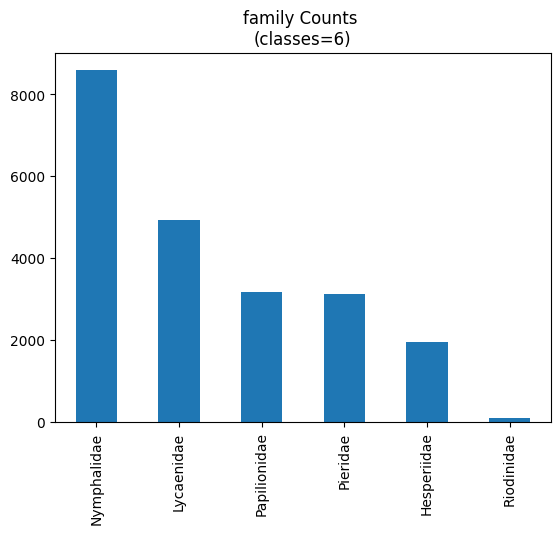

In [ ]:
hp.plot_class_balances(df_train_all,y_col)

In [ ]:
df_train_all['family'].value_counts()

Nymphalidae     8594
Lycaenidae      4941
Papilionidae    3188
Pieridae        3129
Hesperiidae     1964
Riodinidae       112
Name: family, dtype: int64

Looks like our train data classes is horribly imbalanced. Lets fix that.

### Data Sampling


In [ ]:
max_train_pics = 500
max_train_val_pics = int(.2 * max_train_pics)

df_train = hp.sample_df(df_train_all,
                      y_col,
                      n_sample_per_class=max_train_pics,
                      replace = False
                      )

df_test = df_test_all

df_val = df_val_all

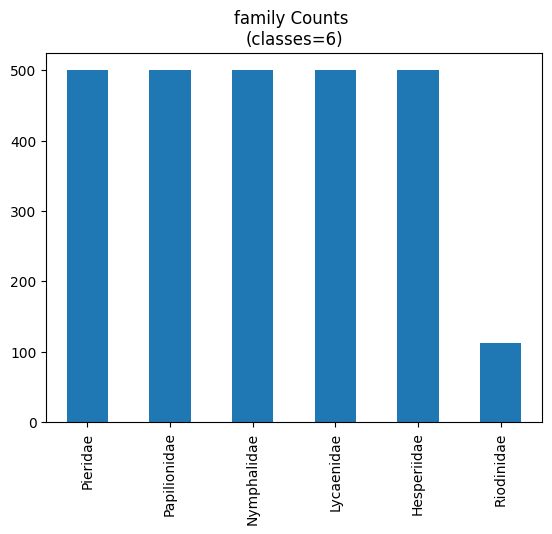

In [ ]:
hp.plot_class_balances(df_train, y_col)

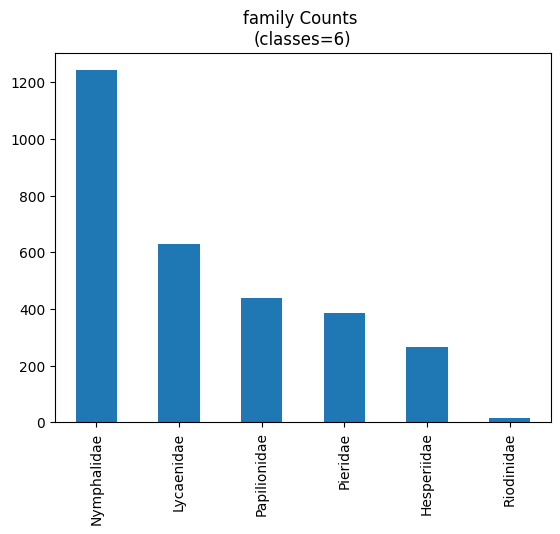

In [ ]:
hp.plot_class_balances(df_val, y_col)

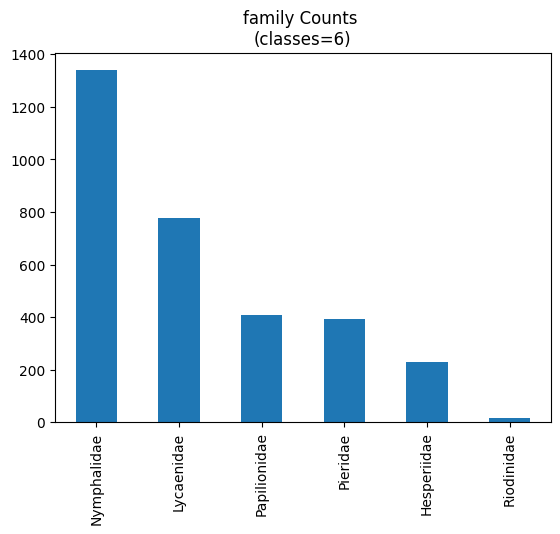

In [ ]:
hp.plot_class_balances(df_test, y_col)

# Data Augmentation


In [ ]:
np.sort(df_train[y_col].unique()).tolist()

['Hesperiidae',
 'Lycaenidae',
 'Nymphalidae',
 'Papilionidae',
 'Pieridae',
 'Riodinidae']

In [ ]:
IMG_SIZE = 224
batch_size = 32

train_classes = df_train[y_col].unique()
train_classes = np.sort(train_classes).tolist()

datagen_train=tf.keras.preprocessing.image.ImageDataGenerator(
                      rescale=1./255,
                      rotation_range=15,
                      width_shift_range=0.2,
                      height_shift_range=0.2,
                      shear_range=0.005,
                      zoom_range=[0.9, 1.4],
                      horizontal_flip=True,
                      vertical_flip=False,
                      brightness_range=(.8,1.2),
                      fill_mode='nearest',
                      )

train_generator=datagen_train.flow_from_dataframe(
    dataframe=df_train,
    directory=images_dir,
    shuffle=True,
    x_col=x_col,
    y_col=y_col,
    classes=train_classes,
    class_mode='sparse',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=batch_size)

Found 2612 validated image filenames belonging to 6 classes.


In [ ]:
train_classes

['Hesperiidae',
 'Lycaenidae',
 'Nymphalidae',
 'Papilionidae',
 'Pieridae',
 'Riodinidae']

In [ ]:
datagen_val=tf.keras.preprocessing.image.ImageDataGenerator(
                      rescale=1./255
                      )

val_generator=datagen_val.flow_from_dataframe(
    dataframe=df_val,
    directory=images_dir,
    x_col=x_col,
    y_col=y_col,
    class_mode='sparse',
    classes=train_classes,
    shuffle=False,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=batch_size)

test_generator = datagen_val.flow_from_dataframe(
    dataframe=df_test,
    directory=images_dir,
    x_col=x_col,
    y_col=y_col,
    class_mode='sparse',
    classes=train_classes,
    shuffle=False,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=batch_size)

Found 2979 validated image filenames belonging to 6 classes.
Found 3165 validated image filenames belonging to 6 classes.


### Viewing the Image Augmentatoin


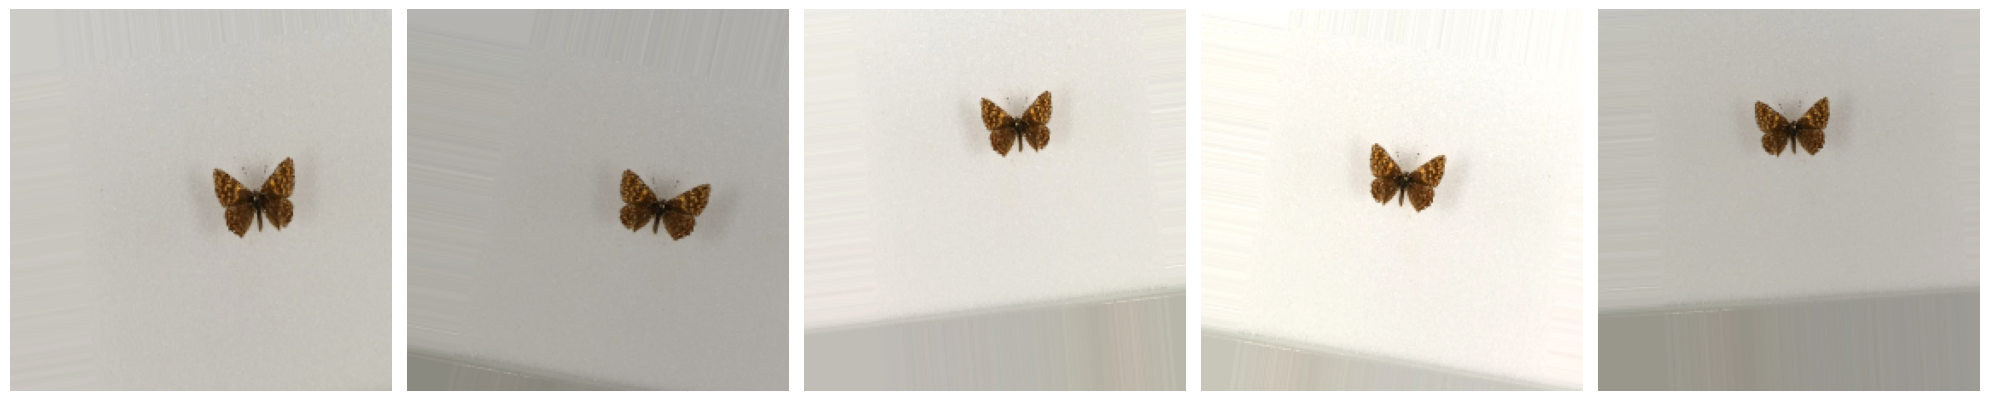

In [ ]:
augmented_images = [train_generator[0][0][0] for i in range(5)]
hp.plotImages(augmented_images)

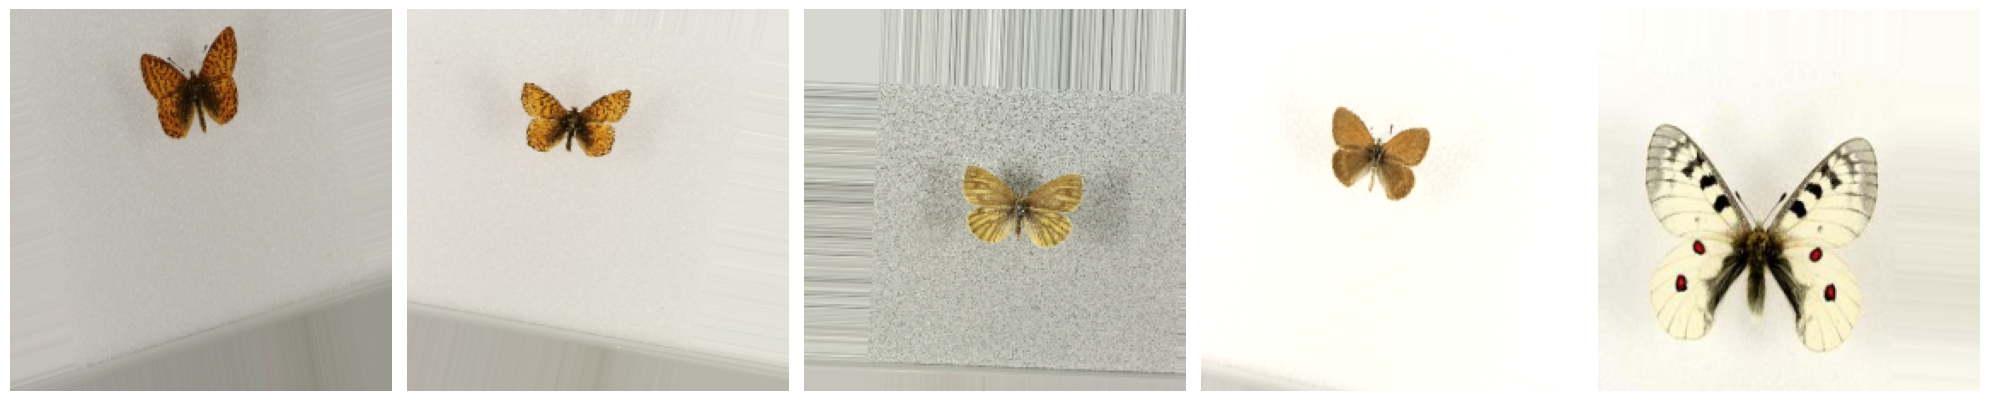

In [ ]:
# Plot 5 images from the train generator
sample_training_images, _ = next(train_generator)
hp.plotImages(sample_training_images[:5])

## Defining steps size


In [ ]:
steps_train = round(train_generator.n / batch_size)
steps_val = round(val_generator.n / batch_size)
steps_test = round(test_generator.n / batch_size)

In [ ]:
cls_val = val_generator.classes
cls_train = train_generator.classes
cls_test = test_generator.classes
len(cls_train)

2612

In [ ]:
steps_train

82

# Class weights

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
class_weight = compute_class_weight(class_weight='balanced',
                                    classes=np.unique(cls_train),
                                    y=cls_train)
class_weight

array([0.87066667, 0.87066667, 0.87066667, 0.87066667, 0.87066667,
       3.88690476])

In [ ]:
class_weight_dict = { i : class_weight[i] for i in range(0, len(class_weight) ) }
class_weight_dict

{0: 0.8706666666666667,
 1: 0.8706666666666667,
 2: 0.8706666666666667,
 3: 0.8706666666666667,
 4: 0.8706666666666667,
 5: 3.886904761904762}

In [ ]:
num_classes = len(class_weight)
num_classes

6

# Baseline CNN


In [ ]:
from tensorflow.keras import layers, models
import keras

In [ ]:
model = models.Sequential()

model.add(layers.Conv2D(16, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(6, activation='softmax'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 64)        18496     
                                                                 
 flatten (Flatten)           (None, 173056)            0

In [ ]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10, monitor='val_loss', restore_best_weights=True)

In [ ]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=["sparse_categorical_accuracy"])


history = model.fit(train_generator,
                    epochs=30,
                    batch_size=32,
                    validation_data=val_generator,
                    callbacks=[early_stopping_cb],
                    class_weight=class_weight_dict,
                    steps_per_epoch=steps_train
                    )

history

Epoch 1/30
82/82 [==============================] - 54s 597ms/step - loss: 1.9519 - sparse_categorical_accuracy: 0.4173 - val_loss: 1.2201 - val_sparse_categorical_accuracy: 0.4622
Epoch 2/30
82/82 [==============================] - 49s 594ms/step - loss: 0.8689 - sparse_categorical_accuracy: 0.6887 - val_loss: 0.9885 - val_sparse_categorical_accuracy: 0.6593
Epoch 3/30
82/82 [==============================] - 50s 611ms/step - loss: 0.6889 - sparse_categorical_accuracy: 0.7404 - val_loss: 0.8688 - val_sparse_categorical_accuracy: 0.7113
Epoch 4/30
82/82 [==============================] - 48s 588ms/step - loss: 0.6366 - sparse_categorical_accuracy: 0.7504 - val_loss: 1.0421 - val_sparse_categorical_accuracy: 0.6432
Epoch 5/30
82/82 [==============================] - 49s 596ms/step - loss: 0.6552 - sparse_categorical_accuracy: 0.7462 - val_loss: 0.7541 - val_sparse_categorical_accuracy: 0.7167
Epoch 6/30
82/82 [==============================] - 50s 616ms/step - loss: 0.5463 - sparse_cate

In [ ]:
pd.DataFrame(history.history)

,loss,sparse_categorical_accuracy,val_loss,val_sparse_categorical_accuracy
0,1.951882,0.417305,1.220133,0.462236
1,0.868929,0.688744,0.988481,0.659282
2,0.688930,0.740429,0.868757,0.711313
3,0.636636,0.750383,1.042061,0.643169
4,0.655248,0.746172,0.754087,0.716683
5,0.546298,0.792879,1.133286,0.659617
6,0.446908,0.829632,1.883348,0.653239
7,0.527118,0.808193,0.765889,0.720712
8,0.404181,0.845329,0.711594,0.752602
9,0.361649,0.867152,0.685667,0.774757


In [ ]:
import matplotlib.pyplot as plt

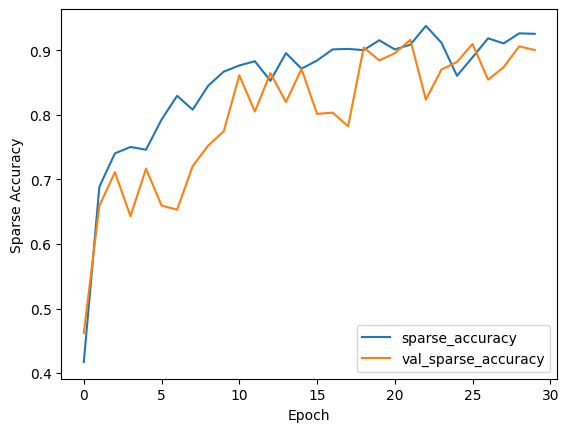

In [ ]:
# Plot the training history.
# Use again the sparse_categorical_accuracy as the metric
plt.plot(history.history['sparse_categorical_accuracy'], label='sparse_accuracy')
plt.plot(history.history['val_sparse_categorical_accuracy'], label = 'val_sparse_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Sparse Accuracy')
plt.legend(loc='lower right')



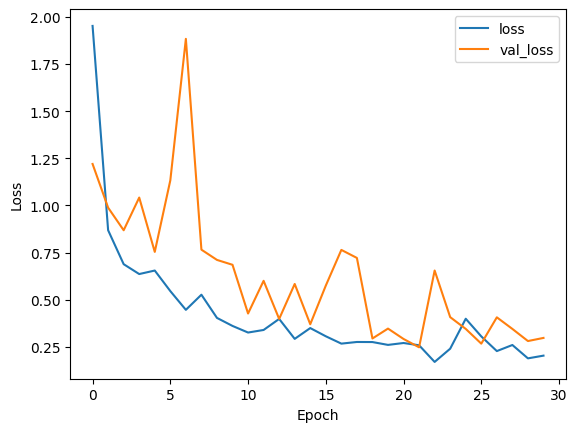

In [ ]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

In [ ]:
test_loss, test_acc = model.evaluate(test_generator, verbose=2)
print(test_acc)

99/99 - 13s - loss: 0.4167 - sparse_categorical_accuracy: 0.8705 - 13s/epoch - 134ms/step
0.8704581260681152


## Transfer Learning - ResNet50

In [ ]:
model_name = 'resnet50_v01'

# load a new instance of the model.
model = tf.keras.applications.resnet50.ResNet50(input_shape=(224,224,3),
                                                include_top=False,
                                                weights='imagenet',
                                                )

In [ ]:
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                       


Then we can add a new 'top' which will act as the decision layer

In [ ]:
len(model.layers)

175

#UNLOCK CNN 5th LAYER TO BE TRAINED

In [ ]:
model.trainable=False

In [ ]:
for layer in model.layers:
  print(layer.name, '-->', layer.trainable)

input_1 --> False
conv1_pad --> False
conv1_conv --> False
conv1_bn --> False
conv1_relu --> False
pool1_pad --> False
pool1_pool --> False
conv2_block1_1_conv --> False
conv2_block1_1_bn --> False
conv2_block1_1_relu --> False
conv2_block1_2_conv --> False
conv2_block1_2_bn --> False
conv2_block1_2_relu --> False
conv2_block1_0_conv --> False
conv2_block1_3_conv --> False
conv2_block1_0_bn --> False
conv2_block1_3_bn --> False
conv2_block1_add --> False
conv2_block1_out --> False
conv2_block2_1_conv --> False
conv2_block2_1_bn --> False
conv2_block2_1_relu --> False
conv2_block2_2_conv --> False
conv2_block2_2_bn --> False
conv2_block2_2_relu --> False
conv2_block2_3_conv --> False
conv2_block2_3_bn --> False
conv2_block2_add --> False
conv2_block2_out --> False
conv2_block3_1_conv --> False
conv2_block3_1_bn --> False
conv2_block3_1_relu --> False
conv2_block3_2_conv --> False
conv2_block3_2_bn --> False
conv2_block3_2_relu --> False
conv2_block3_3_conv --> False
conv2_block3_3_bn --

In [ ]:
for layer in model.layers:
  if 'conv5' in layer.name:
    layer.trainable=True

In [ ]:
for layer in model.layers:
  print(layer.name, '-->', layer.trainable)

input_1 --> False
conv1_pad --> False
conv1_conv --> False
conv1_bn --> False
conv1_relu --> False
pool1_pad --> False
pool1_pool --> False
conv2_block1_1_conv --> False
conv2_block1_1_bn --> False
conv2_block1_1_relu --> False
conv2_block1_2_conv --> False
conv2_block1_2_bn --> False
conv2_block1_2_relu --> False
conv2_block1_0_conv --> False
conv2_block1_3_conv --> False
conv2_block1_0_bn --> False
conv2_block1_3_bn --> False
conv2_block1_add --> False
conv2_block1_out --> False
conv2_block2_1_conv --> False
conv2_block2_1_bn --> False
conv2_block2_1_relu --> False
conv2_block2_2_conv --> False
conv2_block2_2_bn --> False
conv2_block2_2_relu --> False
conv2_block2_3_conv --> False
conv2_block2_3_bn --> False
conv2_block2_add --> False
conv2_block2_out --> False
conv2_block3_1_conv --> False
conv2_block3_1_bn --> False
conv2_block3_1_relu --> False
conv2_block3_2_conv --> False
conv2_block3_2_bn --> False
conv2_block3_2_relu --> False
conv2_block3_3_conv --> False
conv2_block3_3_bn --

In [ ]:
last_conv_layer = model.get_layer('conv5_block3_out')

conv_model = Model(inputs=model.input,
                   outputs=last_conv_layer.output)

five_conv_model = Sequential()

five_conv_model.add(conv_model)

five_conv_model.add(tf.keras.layers.GlobalAveragePooling2D())

five_conv_model.add(layers.Dense(256, activation='relu'))
five_conv_model.add(layers.Dropout(0.2))
five_conv_model.add(layers.Dense(256, activation='relu'))
five_conv_model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))

In [ ]:
five_conv_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
              metrics=["sparse_categorical_accuracy"])

In [ ]:

history = five_conv_model.fit(train_generator,
                    epochs=30,
                    batch_size=32,
                    validation_data=val_generator,
                    callbacks=[early_stopping_cb],
                    class_weight=class_weight_dict,
                    steps_per_epoch=steps_train
                    )

history

Epoch 1/30
82/82 [==============================] - 81s 790ms/step - loss: 1.4727 - sparse_categorical_accuracy: 0.4812 - val_loss: 1.7229 - val_sparse_categorical_accuracy: 0.3468
Epoch 2/30
82/82 [==============================] - 61s 749ms/step - loss: 1.0985 - sparse_categorical_accuracy: 0.6026 - val_loss: 1.6425 - val_sparse_categorical_accuracy: 0.4481
Epoch 3/30
82/82 [==============================] - 66s 807ms/step - loss: 0.9411 - sparse_categorical_accuracy: 0.6424 - val_loss: 1.4315 - val_sparse_categorical_accuracy: 0.3468
Epoch 4/30
82/82 [==============================] - 54s 661ms/step - loss: 0.8139 - sparse_categorical_accuracy: 0.6857 - val_loss: 0.8812 - val_sparse_categorical_accuracy: 0.6109
Epoch 5/30
82/82 [==============================] - 54s 661ms/step - loss: 0.7484 - sparse_categorical_accuracy: 0.7155 - val_loss: 0.6411 - val_sparse_categorical_accuracy: 0.7274
Epoch 6/30
82/82 [==============================] - 55s 669ms/step - loss: 0.7099 - sparse_cate

In [ ]:
import matplotlib.pyplot as plt


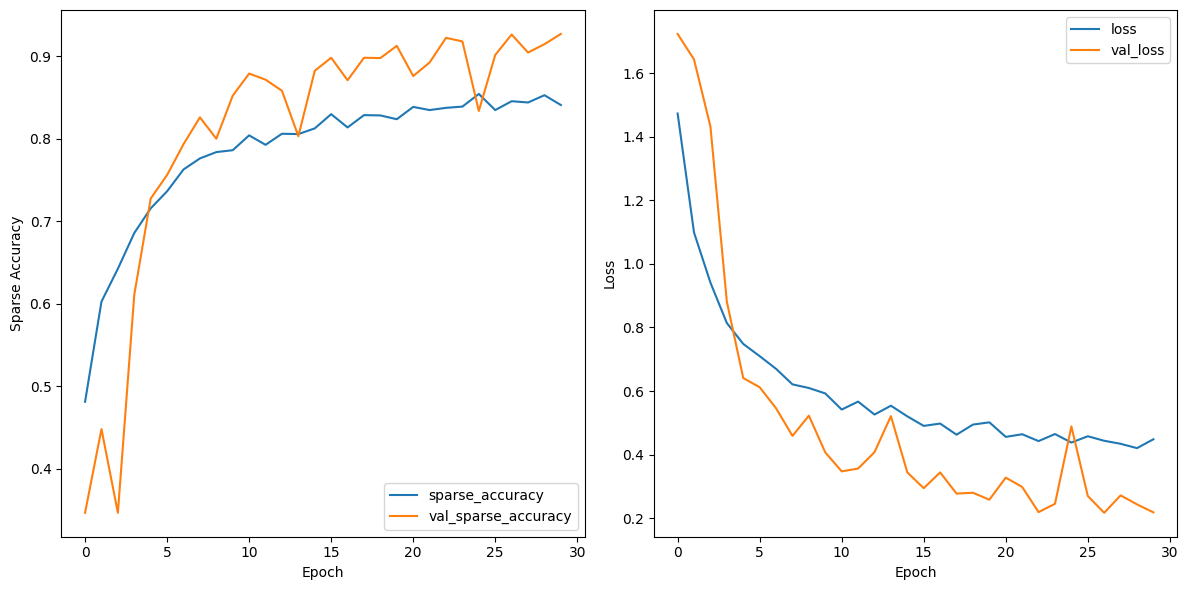

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(12,6))
axes[0].plot(history.history['sparse_categorical_accuracy'], label='sparse_accuracy')
axes[0].plot(history.history['val_sparse_categorical_accuracy'], label = 'val_sparse_accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Sparse Accuracy')
axes[0].legend(loc='lower right')

axes[1].plot(history.history['loss'], label='loss')
axes[1].plot(history.history['val_loss'], label = 'val_loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend(loc='upper right')

plt.tight_layout()
plt.show()

In [ ]:
test_loss, test_acc_five = five_conv_model.evaluate(test_generator, verbose=2)
print(test_acc_five)

99/99 - 12s - loss: 2.1843 - sparse_categorical_accuracy: 0.2408 - 12s/epoch - 117ms/step
0.24075829982757568


In [ ]:
five_test_history = five_conv_model.predict(
                        test_generator,
                        steps=steps_test,
                        batch_size=32,
                        callbacks=None,
                        max_queue_size=10,
                        workers=-1,
                        use_multiprocessing=False,
                        verbose=1)
five_test_history

99/99 [==============================] - 13s 123ms/step


array([[6.7326891e-06, 2.0795338e-05, 4.6065121e-05, 9.9972636e-01,
        1.8776822e-04, 1.2213901e-05],
       [2.6858759e-03, 6.2783842e-04, 9.9556750e-01, 8.5171196e-04,
        7.4417709e-05, 1.9276126e-04],
       [1.0370450e-02, 1.3109408e-01, 8.2170677e-01, 6.9025555e-03,
        4.9055913e-03, 2.5020454e-02],
       ...,
       [2.0996062e-05, 3.7041260e-05, 9.3611350e-05, 9.9942386e-01,
        4.0397490e-04, 2.0550728e-05],
       [6.1281222e-05, 1.1320681e-04, 8.5502752e-04, 9.9844378e-01,
        4.1269549e-04, 1.1404204e-04],
       [1.4592595e-04, 1.7741516e-03, 1.0481459e-03, 9.8891503e-01,
        8.0129653e-03, 1.0384377e-04]], dtype=float32)

..................................................
showing test metrics for 3165 samples
``````````````````````````````````````````````````
                         
accuracy         0.892891
f1_micro         0.892891
precision_micro  0.892891
recall_micro     0.892891
recall_macro     0.836541
f1_macro         0.803571
precision_macro  0.788584
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


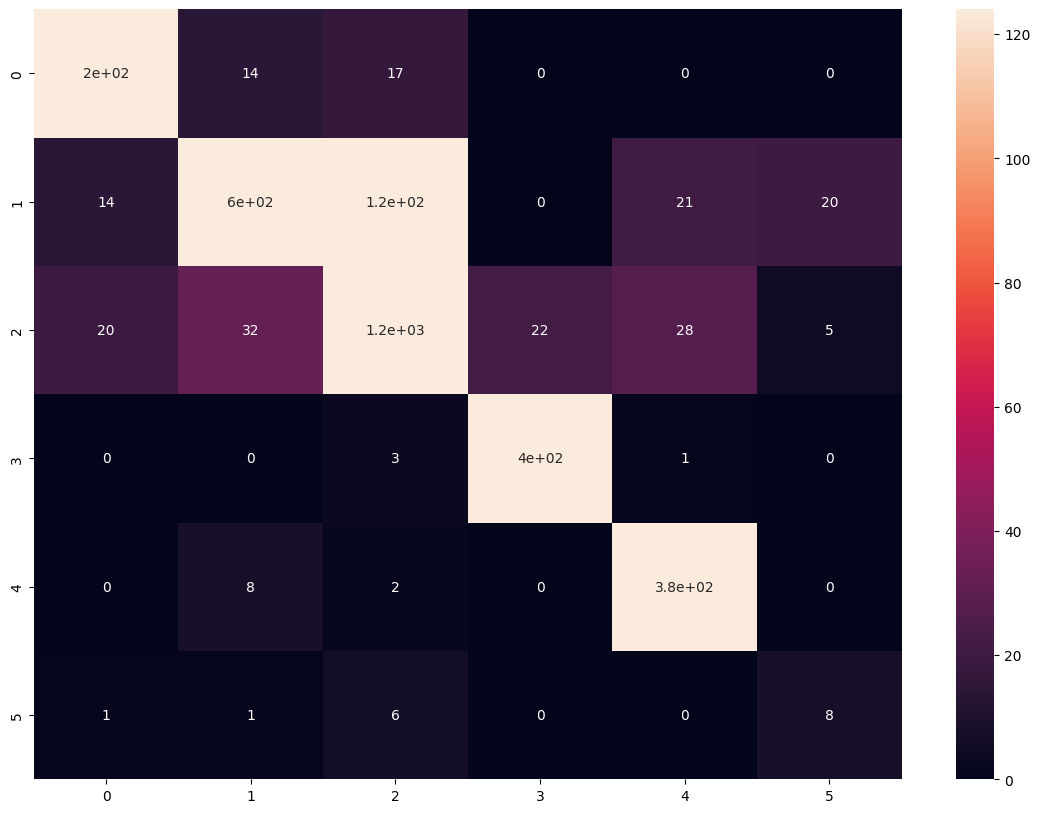

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


In [ ]:
np.bool = np.bool_
df_res_labels = hp.create_test_report(test_generator, five_test_history)

#UNLOCK CNN 4th AND 5th LAYER TO BE TRAINED

In [ ]:
for layer in model.layers:
  if 'conv5' in layer.name:
    layer.trainable=True
  elif 'conv4' in layer.name:
    layer.trainable=True

In [ ]:
for layer in model.layers:
  print(layer.name, '-->', layer.trainable)

input_1 --> False
conv1_pad --> False
conv1_conv --> False
conv1_bn --> False
conv1_relu --> False
pool1_pad --> False
pool1_pool --> False
conv2_block1_1_conv --> False
conv2_block1_1_bn --> False
conv2_block1_1_relu --> False
conv2_block1_2_conv --> False
conv2_block1_2_bn --> False
conv2_block1_2_relu --> False
conv2_block1_0_conv --> False
conv2_block1_3_conv --> False
conv2_block1_0_bn --> False
conv2_block1_3_bn --> False
conv2_block1_add --> False
conv2_block1_out --> False
conv2_block2_1_conv --> False
conv2_block2_1_bn --> False
conv2_block2_1_relu --> False
conv2_block2_2_conv --> False
conv2_block2_2_bn --> False
conv2_block2_2_relu --> False
conv2_block2_3_conv --> False
conv2_block2_3_bn --> False
conv2_block2_add --> False
conv2_block2_out --> False
conv2_block3_1_conv --> False
conv2_block3_1_bn --> False
conv2_block3_1_relu --> False
conv2_block3_2_conv --> False
conv2_block3_2_bn --> False
conv2_block3_2_relu --> False
conv2_block3_3_conv --> False
conv2_block3_3_bn --

In [ ]:
last_conv_layer = model.get_layer('conv5_block3_out')

conv_model = Model(inputs=model.input,
                   outputs=last_conv_layer.output)

fofi_conv_model = Sequential()

fofi_conv_model.add(conv_model)

fofi_conv_model.add(tf.keras.layers.GlobalAveragePooling2D())

fofi_conv_model.add(layers.Dense(256, activation='relu'))
fofi_conv_model.add(layers.Dropout(0.2))
fofi_conv_model.add(layers.Dense(256, activation='relu'))
fofi_conv_model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))

In [ ]:
fofi_conv_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
              metrics=["sparse_categorical_accuracy"])

In [ ]:
fofi_history = fofi_conv_model.fit(train_generator,
                    epochs=30,
                    batch_size=32,
                    validation_data=val_generator,
                    callbacks=[early_stopping_cb],
                    class_weight=class_weight_dict,
                    steps_per_epoch=steps_train
                    )

fofi_history

Epoch 1/30
82/82 [==============================] - 83s 770ms/step - loss: 1.4424 - sparse_categorical_accuracy: 0.4437 - val_loss: 2.8253 - val_sparse_categorical_accuracy: 0.0866
Epoch 2/30
82/82 [==============================] - 71s 870ms/step - loss: 0.9604 - sparse_categorical_accuracy: 0.6784 - val_loss: 1.7059 - val_sparse_categorical_accuracy: 0.3226
Epoch 3/30
82/82 [==============================] - 64s 777ms/step - loss: 0.7155 - sparse_categorical_accuracy: 0.7511 - val_loss: 0.8562 - val_sparse_categorical_accuracy: 0.7304
Epoch 4/30
82/82 [==============================] - 69s 842ms/step - loss: 0.5759 - sparse_categorical_accuracy: 0.8109 - val_loss: 0.4579 - val_sparse_categorical_accuracy: 0.8409
Epoch 5/30
82/82 [==============================] - 57s 698ms/step - loss: 0.5074 - sparse_categorical_accuracy: 0.8338 - val_loss: 0.3191 - val_sparse_categorical_accuracy: 0.8892
Epoch 6/30
82/82 [==============================] - 57s 691ms/step - loss: 0.4514 - sparse_cate

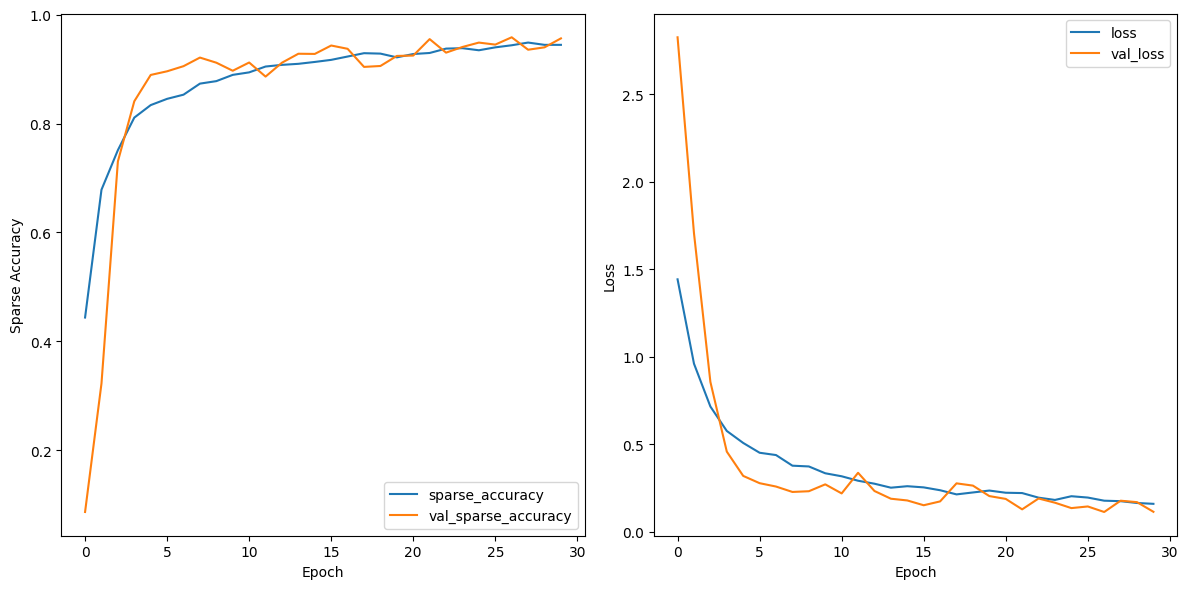

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(12,6))
axes[0].plot(fofi_history.history['sparse_categorical_accuracy'], label='sparse_accuracy')
axes[0].plot(fofi_history.history['val_sparse_categorical_accuracy'], label = 'val_sparse_accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Sparse Accuracy')
axes[0].legend(loc='lower right')

axes[1].plot(fofi_history.history['loss'], label='loss')
axes[1].plot(fofi_history.history['val_loss'], label = 'val_loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend(loc='upper right')

plt.tight_layout()
plt.show()

In [ ]:
test_loss, test_acc_fofi = fofi_conv_model.evaluate(test_generator, verbose=2)
print(test_acc_fofi)

99/99 - 12s - loss: 0.7044 - sparse_categorical_accuracy: 0.7839 - 12s/epoch - 118ms/step
0.7838862538337708


In [ ]:
fofi_test_history = fofi_conv_model.predict(
                        test_generator,
                        steps=steps_test,
                        batch_size=32,
                        callbacks=None,
                        max_queue_size=10,
                        workers=-1,
                        use_multiprocessing=False,
                        verbose=1)
fofi_test_history

99/99 [==============================] - 14s 132ms/step


array([[1.8758681e-05, 6.4730725e-06, 3.7272612e-06, 9.9996471e-01,
        3.3955228e-06, 2.9173832e-06],
       [6.0433023e-05, 6.0998616e-05, 9.9959773e-01, 3.1000363e-05,
        2.4360759e-04, 6.3203629e-06],
       [8.2991822e-03, 2.4587418e-01, 6.3388586e-01, 5.7466035e-03,
        2.5155607e-03, 1.0367861e-01],
       ...,
       [4.7616199e-05, 2.1658272e-05, 1.5825717e-05, 9.9988997e-01,
        1.1170828e-05, 1.3729638e-05],
       [9.8730387e-05, 3.8102378e-05, 3.1295895e-05, 9.9980360e-01,
        1.4851032e-05, 1.3361718e-05],
       [2.7218279e-05, 2.5305539e-05, 8.1303688e-06, 9.9992144e-01,
        7.6178644e-06, 1.0260220e-05]], dtype=float32)

..................................................
showing test metrics for 3165 samples
``````````````````````````````````````````````````
                         
f1_micro         0.919747
accuracy         0.919747
precision_micro  0.919747
recall_micro     0.919747
recall_macro     0.886069
f1_macro         0.834049
precision_macro  0.823582
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


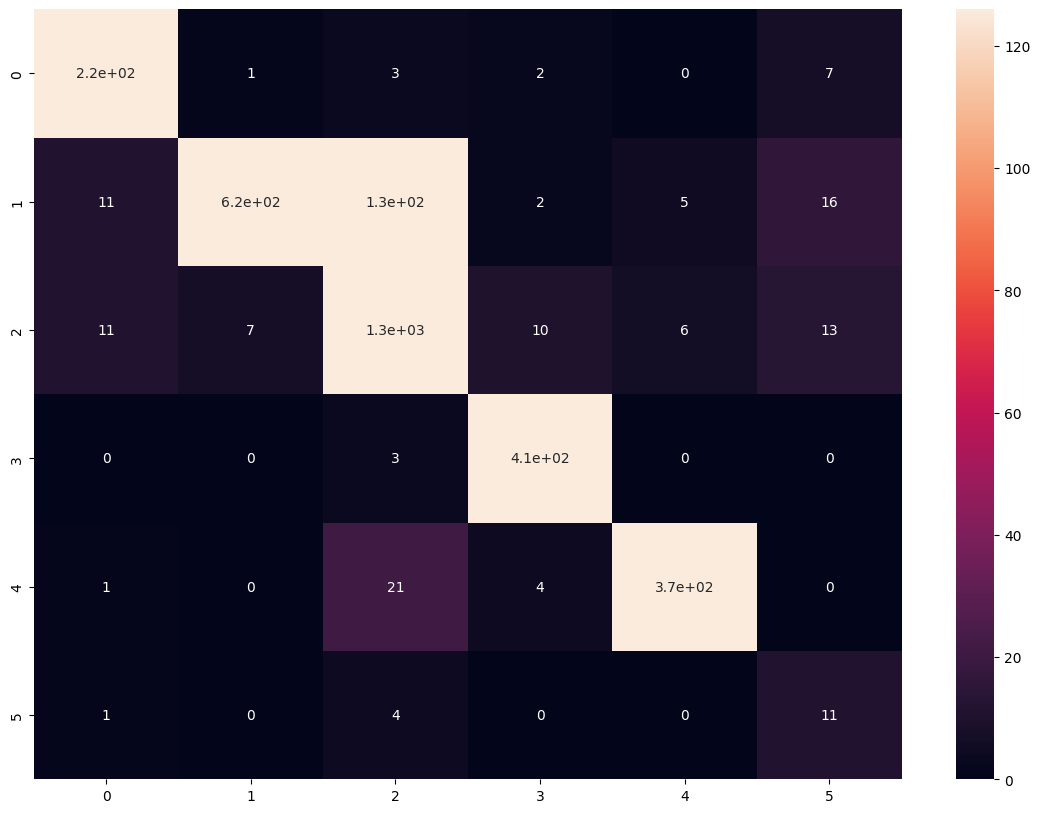

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


In [ ]:
np.bool = np.bool_
df_res_labels = hp.create_test_report(test_generator, fofi_test_history)

#UNLOCK CNN 3rd, 4th AND 5th LAYER TO BE TRAINED

In [ ]:
for layer in model.layers:
  if 'conv5' in layer.name:
    layer.trainable=True
  elif 'conv4' in layer.name:
    layer.trainable=True
  elif 'conv3' in layer.name:
    layer.trainable=True

In [ ]:
for layer in model.layers:
  print(layer.name, '-->', layer.trainable)

input_1 --> False
conv1_pad --> False
conv1_conv --> False
conv1_bn --> False
conv1_relu --> False
pool1_pad --> False
pool1_pool --> False
conv2_block1_1_conv --> False
conv2_block1_1_bn --> False
conv2_block1_1_relu --> False
conv2_block1_2_conv --> False
conv2_block1_2_bn --> False
conv2_block1_2_relu --> False
conv2_block1_0_conv --> False
conv2_block1_3_conv --> False
conv2_block1_0_bn --> False
conv2_block1_3_bn --> False
conv2_block1_add --> False
conv2_block1_out --> False
conv2_block2_1_conv --> False
conv2_block2_1_bn --> False
conv2_block2_1_relu --> False
conv2_block2_2_conv --> False
conv2_block2_2_bn --> False
conv2_block2_2_relu --> False
conv2_block2_3_conv --> False
conv2_block2_3_bn --> False
conv2_block2_add --> False
conv2_block2_out --> False
conv2_block3_1_conv --> False
conv2_block3_1_bn --> False
conv2_block3_1_relu --> False
conv2_block3_2_conv --> False
conv2_block3_2_bn --> False
conv2_block3_2_relu --> False
conv2_block3_3_conv --> False
conv2_block3_3_bn --

In [ ]:
last_conv_layer = model.get_layer('conv5_block3_out')

conv_model = Model(inputs=model.input,
                   outputs=last_conv_layer.output)

thfofi_conv_model = Sequential()

thfofi_conv_model.add(conv_model)

thfofi_conv_model.add(tf.keras.layers.GlobalAveragePooling2D())

thfofi_conv_model.add(layers.Dense(256, activation='relu'))
thfofi_conv_model.add(layers.Dropout(0.2))
thfofi_conv_model.add(layers.Dense(256, activation='relu'))
thfofi_conv_model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))

In [ ]:
thfofi_conv_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
              metrics=["sparse_categorical_accuracy"])

In [ ]:
thfofi_history = thfofi_conv_model.fit(train_generator,
                    epochs=30,
                    batch_size=32,
                    validation_data=val_generator,
                    callbacks=[early_stopping_cb],
                    class_weight=class_weight_dict,
                    steps_per_epoch=steps_train
                    )

thfofi_history

Epoch 1/30
82/82 [==============================] - 85s 717ms/step - loss: 1.1967 - sparse_categorical_accuracy: 0.6030 - val_loss: 2.0275 - val_sparse_categorical_accuracy: 0.1356
Epoch 2/30
82/82 [==============================] - 59s 722ms/step - loss: 0.4844 - sparse_categorical_accuracy: 0.8649 - val_loss: 2.0594 - val_sparse_categorical_accuracy: 0.2910
Epoch 3/30
82/82 [==============================] - 61s 747ms/step - loss: 0.2919 - sparse_categorical_accuracy: 0.9165 - val_loss: 1.5856 - val_sparse_categorical_accuracy: 0.3276
Epoch 4/30
82/82 [==============================] - 69s 842ms/step - loss: 0.2022 - sparse_categorical_accuracy: 0.9410 - val_loss: 0.9450 - val_sparse_categorical_accuracy: 0.6304
Epoch 5/30
82/82 [==============================] - 70s 850ms/step - loss: 0.1646 - sparse_categorical_accuracy: 0.9506 - val_loss: 0.4602 - val_sparse_categorical_accuracy: 0.8523
Epoch 6/30
82/82 [==============================] - 60s 733ms/step - loss: 0.1411 - sparse_cate

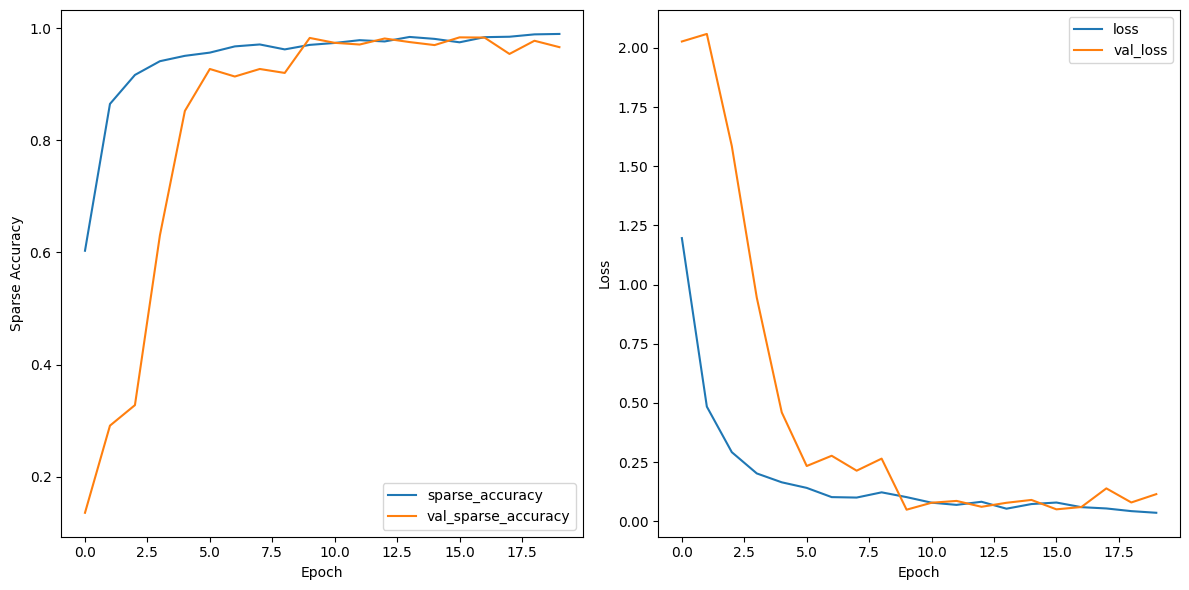

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(12,6))
axes[0].plot(thfofi_history.history['sparse_categorical_accuracy'], label='sparse_accuracy')
axes[0].plot(thfofi_history.history['val_sparse_categorical_accuracy'], label = 'val_sparse_accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Sparse Accuracy')
axes[0].legend(loc='lower right')

axes[1].plot(thfofi_history.history['loss'], label='loss')
axes[1].plot(thfofi_history.history['val_loss'], label = 'val_loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend(loc='upper right')

plt.tight_layout()
plt.show()

In [ ]:
test_loss, test_acc_thfofi = thfofi_conv_model.evaluate(test_generator, verbose=2)
print(test_acc_thfofi)

99/99 - 12s - loss: 0.1053 - sparse_categorical_accuracy: 0.9630 - 12s/epoch - 122ms/step
0.9630331993103027


In [ ]:
thfofi_test_history = thfofi_conv_model.predict(
                        test_generator,
                        steps=steps_test,
                        batch_size=32,
                        callbacks=None,
                        max_queue_size=10,
                        workers=-1,
                        use_multiprocessing=False,
                        verbose=1)
thfofi_test_history

99/99 [==============================] - 13s 117ms/step


array([[1.3657402e-05, 1.8982737e-05, 1.0804285e-05, 9.9988091e-01,
        2.0790225e-05, 5.4798402e-05],
       [4.4652978e-05, 1.2690279e-04, 9.9969256e-01, 6.7742629e-05,
        3.1555748e-05, 3.6628324e-05],
       [1.4872845e-03, 1.6005689e-02, 9.7014868e-01, 2.5324619e-03,
        1.3959232e-03, 8.4299315e-03],
       ...,
       [2.2691343e-05, 1.7674362e-05, 7.4152804e-06, 9.9992096e-01,
        1.3193852e-05, 1.8073199e-05],
       [1.3818205e-04, 8.6406260e-05, 1.9762243e-04, 9.9922740e-01,
        2.0901850e-04, 1.4146058e-04],
       [1.2400888e-05, 7.2427342e-06, 6.7816927e-06, 9.9994123e-01,
        6.4349806e-06, 2.5877142e-05]], dtype=float32)

..................................................
showing test metrics for 3165 samples
``````````````````````````````````````````````````
                         
accuracy         0.963033
f1_micro         0.963033
precision_micro  0.963033
recall_micro     0.963033
precision_macro  0.946935
f1_macro         0.931183
recall_macro     0.919256
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


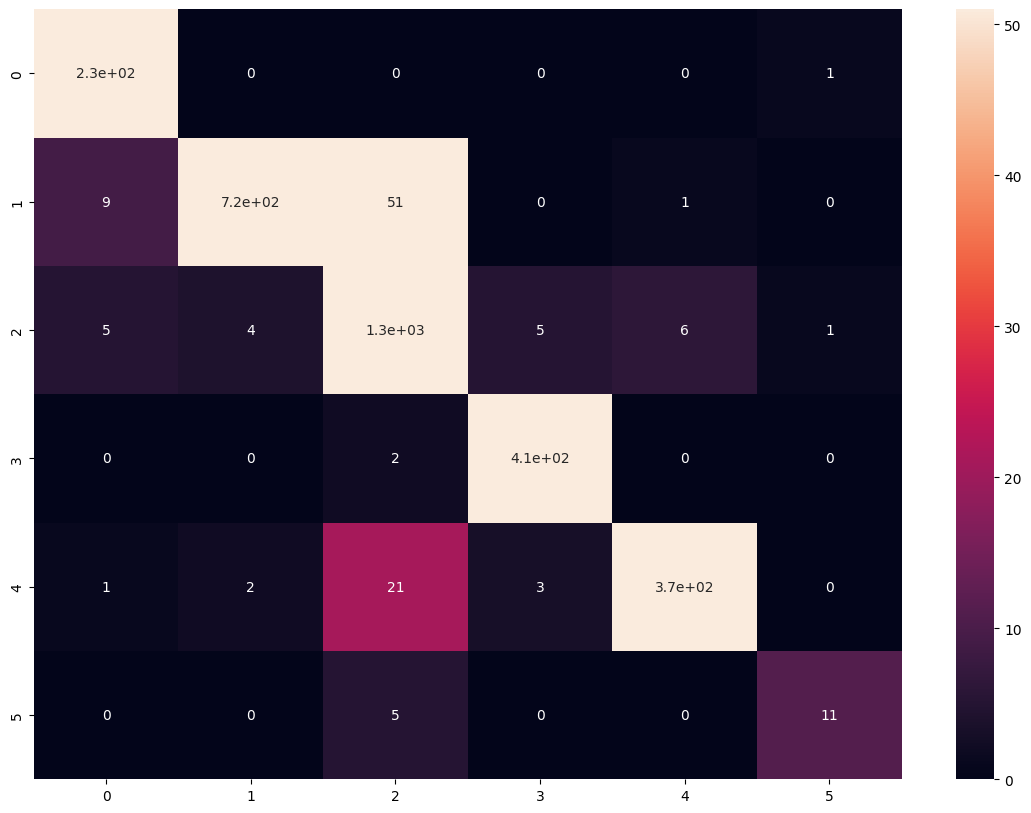

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


In [ ]:
np.bool = np.bool_
df_res_labels = hp.create_test_report(test_generator, thfofi_test_history)

#UNLOCK ALL CNN LAYERS

In [ ]:
for layer in model.layers[:fine_tune_at]:
  layer.trainable =  True

In [ ]:
last_conv_layer = model.get_layer('conv5_block3_out')

conv_model = Model(inputs=model.input,
                   outputs=last_conv_layer.output)

all_conv_model = Sequential()

all_conv_model.add(conv_model)

all_conv_model.add(tf.keras.layers.GlobalAveragePooling2D())

all_conv_model.add(layers.Dense(256, activation='relu'))
all_conv_model.add(layers.Dropout(0.2))
all_conv_model.add(layers.Dense(256, activation='relu'))
all_conv_model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))


all_conv_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
              metrics=["sparse_categorical_accuracy"])


all_conv_history = all_conv_model.fit(train_generator,
                    epochs=30,
                    batch_size=32,
                    validation_data=val_generator,
                    callbacks=[early_stopping_cb],
                    class_weight=class_weight_dict,
                    steps_per_epoch=steps_train
                    )

all_conv_history

Epoch 1/30
82/82 [==============================] - 101s 833ms/step - loss: 1.1439 - sparse_categorical_accuracy: 0.6179 - val_loss: 1.8267 - val_sparse_categorical_accuracy: 0.2877
Epoch 2/30
82/82 [==============================] - 74s 898ms/step - loss: 0.4107 - sparse_categorical_accuracy: 0.9185 - val_loss: 1.8295 - val_sparse_categorical_accuracy: 0.1339
Epoch 3/30
82/82 [==============================] - 66s 801ms/step - loss: 0.2018 - sparse_categorical_accuracy: 0.9544 - val_loss: 1.8187 - val_sparse_categorical_accuracy: 0.1014
Epoch 4/30
82/82 [==============================] - 72s 882ms/step - loss: 0.1434 - sparse_categorical_accuracy: 0.9667 - val_loss: 1.8262 - val_sparse_categorical_accuracy: 0.1457
Epoch 5/30
82/82 [==============================] - 63s 771ms/step - loss: 0.0938 - sparse_categorical_accuracy: 0.9755 - val_loss: 1.6879 - val_sparse_categorical_accuracy: 0.2806
Epoch 6/30
82/82 [==============================] - 60s 731ms/step - loss: 0.0654 - sparse_cat

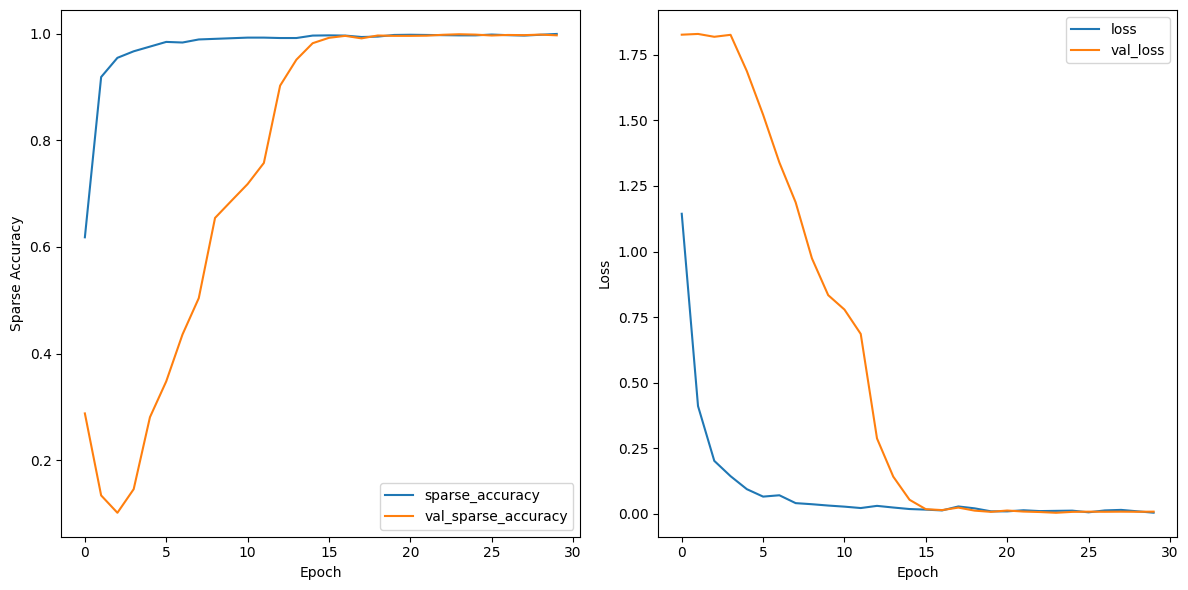

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(12,6))
axes[0].plot(all_conv_history.history['sparse_categorical_accuracy'], label='sparse_accuracy')
axes[0].plot(all_conv_history.history['val_sparse_categorical_accuracy'], label = 'val_sparse_accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Sparse Accuracy')
axes[0].legend(loc='lower right')

axes[1].plot(all_conv_history.history['loss'], label='loss')
axes[1].plot(all_conv_history.history['val_loss'], label = 'val_loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend(loc='upper right')

plt.tight_layout()
plt.show()

In [ ]:
test_loss, test_acc_all = thfofi_conv_model.evaluate(test_generator, verbose=2)
print(test_acc_all)

99/99 - 16s - loss: 0.1053 - sparse_categorical_accuracy: 0.9630 - 16s/epoch - 162ms/step
0.9630331993103027


99/99 [==============================] - 15s 117ms/step
..................................................
showing test metrics for 3165 samples
``````````````````````````````````````````````````
                         
precision_macro  0.981754
precision_micro  0.969352
accuracy         0.969352
recall_micro     0.969352
f1_micro         0.969352
f1_macro         0.947381
recall_macro     0.923585
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


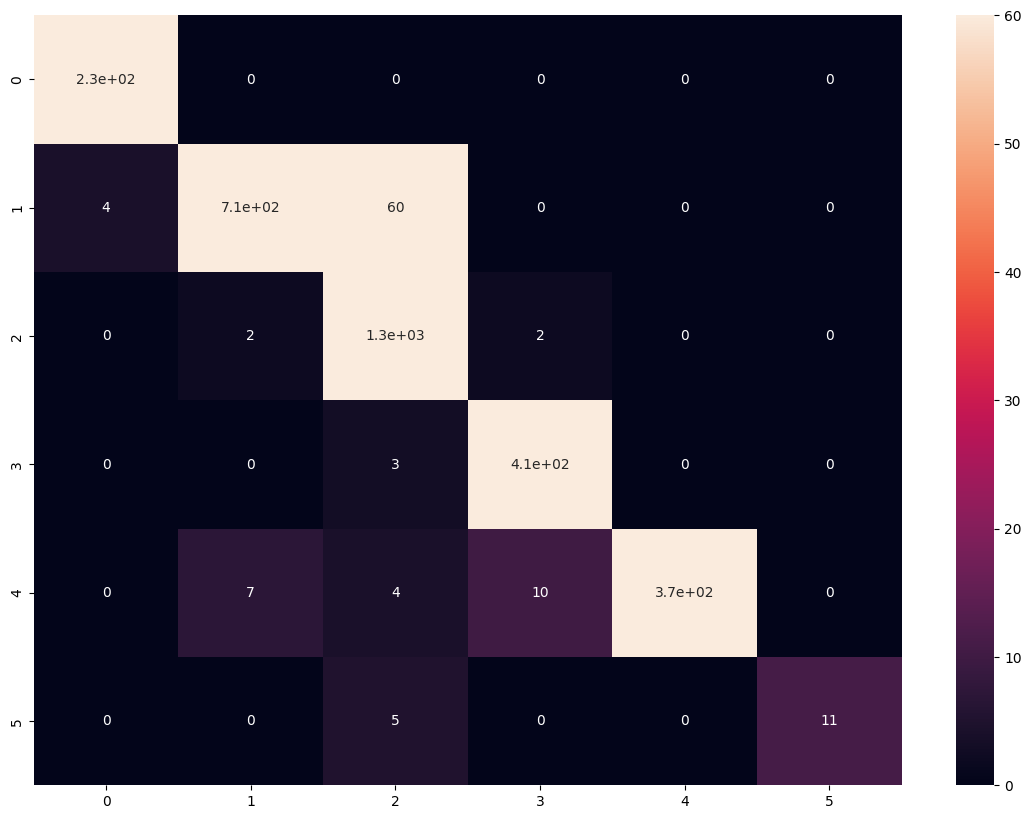

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


In [ ]:
all_test_history = all_conv_model.predict(
                        test_generator,
                        steps=steps_test,
                        batch_size=32,
                        callbacks=None,
                        max_queue_size=10,
                        workers=-1,
                        use_multiprocessing=False,
                        verbose=1)

np.bool = np.bool_
df_res_labels = hp.create_test_report(test_generator, all_test_history)

# Comparison of Accuracy

In [ ]:
tests_accuracy = (test_acc_five, test_acc_fofi, test_acc_thfofi, test_acc_all)
test_accuracy_finetune=[i for i in tests_accuracy]
test_accuracy_names = ['Layer 5', 'Layer 4 and 5', 'Layer 3, 4 and 5', 'All Layers']
pd.DataFrame({'Amount of Trainable Layers': test_accuracy_names, 'Sparse Categorical Accuracy': test_accuracy_finetune})

,Amount of Trainable Layers,Sparse Categorical Accuracy
0,Layer 5,0.240758
1,Layer 4 and 5,0.783886
2,"Layer 3, 4 and 5",0.963033
3,All Layers,0.963033


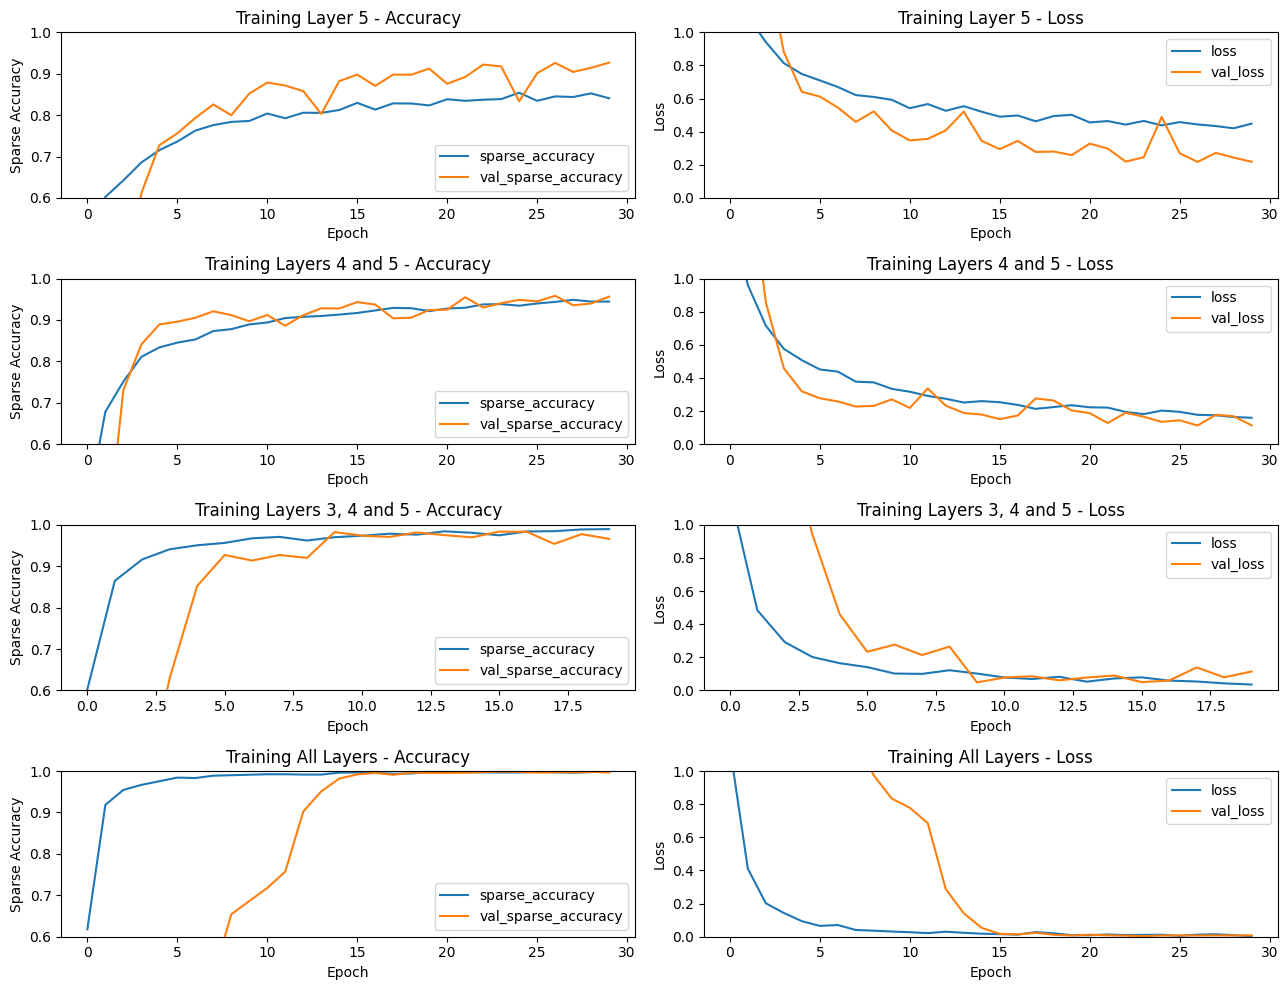

In [ ]:
diff_models = (history, fofi_history, thfofi_history, all_conv_history)

fig, axes = plt.subplots(4,2, figsize=(13,10))

for row, model in enumerate(diff_models):
  titles_accuracy = ['Training Layer 5 - Accuracy', 'Training Layers 4 and 5 - Accuracy', 'Training Layers 3, 4 and 5 - Accuracy', 'Training All Layers - Accuracy']
  titles_loss = ['Training Layer 5 - Loss', 'Training Layers 4 and 5 - Loss', 'Training Layers 3, 4 and 5 - Loss', 'Training All Layers - Loss']
  axes[row,0].plot(model.history['sparse_categorical_accuracy'], label='sparse_accuracy')
  axes[row,0].plot(model.history['val_sparse_categorical_accuracy'], label = 'val_sparse_accuracy')
  axes[row,0].set_xlabel('Epoch')
  axes[row,0].set_ylabel('Sparse Accuracy')
  axes[row,0].legend(loc='lower right')
  axes[row,0].set_ylim(0.6,1)
  axes[row,0].set_title(titles_accuracy[row])
  for col in range(1,2):
    axes[row,col].plot(model.history['loss'], label='loss')
    axes[row,col].plot(model.history['val_loss'], label = 'val_loss')
    axes[row,col].set_xlabel('Epoch')
    axes[row,col].set_ylabel('Loss')
    axes[row,col].legend(loc='upper right')
    axes[row,col].set_ylim(0,1)
    axes[row,col].set_title(titles_loss[row])

plt.tight_layout()
plt.show()